# Chap8の前半で学ぶこと
* 多くの問題では、ネットワークを深くすることで、性能の向上が期待できる。
* ILSVRCと呼ばれる画像認識のコンペティションの最近の動向は、ディープラーニングによる手法が上位を独占し、使われるネットワークもディープ化している。
* 有名なネットワークには、VGG、GoogLeNet、ResNetがある。
* GPUや分散学習、ビット精度の削減などによってディープラーニングの高速化を実現できる。

# よりディープなネットワークの実装

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """認識率99%以上の高精度なConvNet

    ネットワーク構成は下記の通り
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1}, #チャンネル数は16
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1}, #チャンネル数は16
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1}, #チャンネル数は32
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1}, #チャンネル数は32
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1}, #チャンネル数は64
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1}, #チャンネル数は64
                 hidden_size=50, output_size=10): #隠れ層のニューロン数：50、出力層のニューロン数：10
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか（TODO:自動で計算する）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        weight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLUを使う場合に推奨される初期値
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = weight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = weight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        '''
        * self.layersリストにレイヤーを追加する順番がそのままネットワークの構造になる
        * predictメソッドでfor layer in self.layers:として順番に処理される
        * 最後のSoftmax層だけはself.last_layerとして別に管理されている
        '''
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))

        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))

        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))

        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.2702400210195477
=== epoch:1, train acc:0.099, test acc:0.104 ===
train loss:2.2869748415832554
train loss:2.325626686413584
train loss:2.2026127812034084
train loss:2.256364573149047
train loss:2.275997023896389
train loss:2.2301847237225694
train loss:2.2372891966559534
train loss:2.1934879111798757
train loss:2.0962439105031248
train loss:2.212988383233301
train loss:2.141151829984635
train loss:2.0489500712176936
train loss:2.030571861060726
train loss:2.1333111916611673
train loss:2.110424168824256
train loss:2.088856063020338
train loss:1.9823707897701064
train loss:2.0514704656267515
train loss:2.088269273512255
train loss:2.0591503031056497
train loss:2.146317684865091
train loss:1.9398894179106885
train loss:1.9713697024263832
train loss:1.9079930215135203
train loss:1.9472480966174432
train loss:1.951958256637464
train loss:1.723044226820951
train loss:1.753785135346979
train loss:1.8307913690217104
train loss:1.914130315725152
train loss:1.7913663253898335
train

# 結果まとめ

**final accracy: 99.32%**  
**running time: 89m 16.1s**  

epoch7で達成されている。

=== epoch:1, train acc:0.099, test acc:0.104 ===
=== epoch:2, train acc:0.974, test acc:0.972 ===
=== epoch:3, train acc:0.985, test acc:0.981 ===
=== epoch:4, train acc:0.989, test acc:0.987 ===
=== epoch:5, train acc:0.991, test acc:0.988 ===
=== epoch:6, train acc:0.991, test acc:0.989 ===
=== epoch:7, train acc:0.992, test acc:0.99 ===
=== epoch:8, train acc:0.991, test acc:0.986 ===
=== epoch:9, train acc:0.994, test acc:0.984 ===
=== epoch:10, train acc:0.993, test acc:0.985 ===
=== epoch:11, train acc:0.997, test acc:0.989 ===
=== epoch:12, train acc:0.993, test acc:0.991 ===
=== epoch:13, train acc:0.996, test acc:0.987 ===
=== epoch:14, train acc:0.995, test acc:0.988 ===
=== epoch:15, train acc:0.995, test acc:0.994 ===
=== epoch:16, train acc:0.997, test acc:0.986 ===
=== epoch:17, train acc:0.995, test acc:0.99 ===
=== epoch:18, train acc:0.999, test acc:0.991 ===
=== epoch:19, train acc:0.997, test acc:0.991 ===
=== epoch:20, train acc:0.998, test acc:0.992 ===

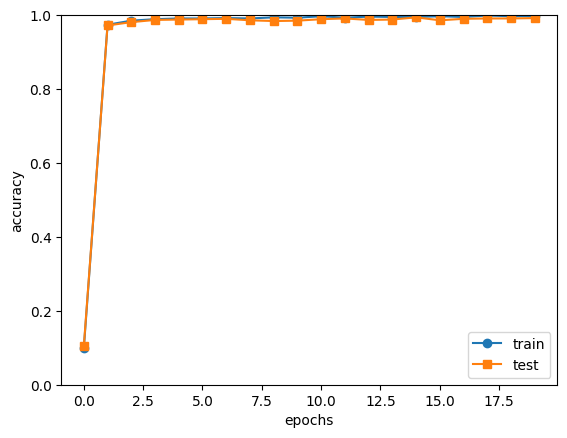

In [6]:
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(20) #max epochs = 20
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=1)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=1)
plt.xlabel("epochs")
plt.ylim(0, 21.0)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

> MNISTデータセットに対しては、層をそこまで深くせずに（現時点では）最高精度の結果が得られています。  
これは、手書き数字という比較的単純な問題に対しては、ネットワークの表現力をそこまで高める必要がないからだと考えられます。  
そのため、層を深くすることの恩恵が少ないと言えるでしょう。  
この後に紹介する大規模な一般物体認識では、問題が複雑になるため、層を深くすることが認識精度の向上に大いに貢献することが分かります。

p.245のカラス

# さらに認識制度を高めるには
rankingやtrendingを追うサイト:  
Paper with code -> Hagging face. 

* アンサンブル学習(p.197)：複数の異なるモデルを組み合わせて、より高精度な予測を行う手法（過学習を回避）
* 学習係数の減衰（learning rate decay）：初期は大きな学習率で素早く最適解に近づく→学習が進むにつれて学習率を減衰させ、細かい調整を行う
* Data Augmentation（データ拡張）：既存の学習データに変換を加えて、実質的にデータ量を増やす手法


# 層を深くするモチベーション
* 重要性：（経験的に）層を深くすることに比例して、認識性能も向上している
* 利点（CNNを例に）
    * 層を深くしたネットワークは、層を深くしなかった場合に比べて、より少ないパラメータで同レベル（もしくはそれ以上）の表現力を達成できる
        * 例えば、5×5の畳み込み演算1回 VS 3×3の畳み込み演算を2回 の比較では、パラメータ数（フィルターの要素数の合計）は25（5×5） VS 18（2×3×3）
        * 小さなフィルターでも受容野をカバーできる
    * 層を重ねることで、畳み込み層の間にReLUなどの活性化関数を挟むことができ、ネットワークの表現力がさらに向上する
    * ネットワークを深くすれば、学習すべき問題を階層的に分解することができる
        * 層を深くすることで階層的に情報を渡していくことができる
        * 各層が学習すべき問題は、より単純な問題として取り組むことができる

# ディープラーニングの小歴史
## ImageNet
* データセットのこと
* ILSVRCは2017年で終了（精度向上の余地がなくなったため）
* 2012年のAlexnet登場前までは、SIFT（Scale-Invariant Feature Transform）やHOG（Histogram of Oriented Gradients）などの手工芸特徴量（hand-crafted features）を用いた手法が中心
## VGG
* 基本的なCNN
* 3×3の小さなフィルターによる畳み込み層を連続して行う
## GoogLeNet
* インセプション構造（図8-11）：サイズの異なるフィルター（とプーリング）を複数適用しその結果を結合する
## ResNet (Residual Network: 残差ネットワーク)
* "スキップ構造"はTransformerでも応用されている。

# GPUによる高速化
* GPUは元々、グラフィックのための専用のボードとして利用されてきた
* 並列的な数値演算を高速に行うことができるため、汎用的な数値計算にも活用

# 分散学習
* 大量のデータや計算処理を複数のマシンやプロセッサに分散して並列処理する手法
* アンサンブル学習(p.198)は、複数の学習モデルを組み合わせて予測精度を向上させる手法

# 演算精度のビット削減
**データのビット数はできるだけ小さい方がいい**
* メモリ容量：大量の重みパラメータや中間データをメモリに収めらるか
* バス帯域（CPU・GPUとメモリの間の道を流れるデータ量の上限値）：GPU（もしくはCPU）のバスを流れるデータが増加に耐えうるか
**経験的にディープラーニングのロバスト性（頑健性）がわかっている**
* ディープラーニングでは、数値精度（何ビットのデータで数値を表現するかということ）のビット数をそこまで必要としないことがわかっている
* ロバスト性のおかげで、ネットワークを流れるデータを“劣化”させても、出力結果に与える影響は少ない

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 高速化のため
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16に型変換
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

caluculate accuracy (float64) ... 
0.9932
caluculate accuracy (float16) ... 
0.9932


15s 14s
⇧ float16でもaccuracyが維持されている。

BitNet b1.58まで到達（2024年）